In [1]:
import os
import os.path as op

import matplotlib.pyplot as plt
import numpy as np

import sys
module_path = op.abspath("/net/store/nbp/projects/MindQ/src/")
if module_path not in sys.path:
    sys.path.append(module_path)
    
import pandas

from mindq_nslr.io import load_mindq, crop_df, save_pickle, add_events, add_segmentation
from mindq_nslr.utils import mark_by_distance
from mindq_nslr.classification import preprocess
from cateye import (plot_segmentation, plot_nslr_segmentation, plot_trajectory,
                    classify_nslr_hmm, classify_remodnav, discrete_to_continuous,
                    continuous_to_discrete)

import warnings
warnings.filterwarnings('ignore')

In [8]:
# Change only these parameters during classification
eye = "RightEye"
condition = "concussion"

### define directories
file_dir = op.join("/net/store/nbp/projects/MindQ/data", condition)
result_dir = op.join("/net/store/nbp/projects/MindQ/results", condition)
sub_dirs = [i[:36] for i in os.listdir(op.join(file_dir, eye))][:5]  # !!!remve before deployment
sub_dir = sub_dirs[0]

# load the data and events
df = load_mindq(op.join(file_dir, eye, sub_dir + "_" + eye + ".csv"))
df.index = pandas.to_timedelta(df["Timestamp"], unit="S")
df = df.sort_index()
df.head()

In [3]:
# interpolate constants
for col in ["Theta", "Phi"]:
    mask = [i in (0, 1) for i in df[col]]
    df[col][mask] = np.nan
df = df.interpolate()

# convert radian data format to degree
df[["Theta", "Phi"]] = df[["Theta", "Phi"]].apply(np.rad2deg)

# Apply a median boxcar to our gaze data
boxcar_size = 3
df[["Theta", "Phi"]] = df[["Theta", "Phi"]].rolling(boxcar_size).median()
df[["Theta", "Phi"]] = df[["Theta", "Phi"]].fillna(method='backfill')

# crop the recording between 80 and 160 seconds
start = 180 #80
stop = 260 #160
df = df.loc[(df["Timestamp"] >= start) & (df["Timestamp"] <= stop)]

# resample to 200 Hz
sfreq = 200
df = df.resample(f"{1/sfreq}S").mean().interpolate()

In [4]:
event_df = pandas.read_csv(op.join(file_dir, "Events", sub_dir + "_Events.csv"))
event_df.head()

,Unnamed: 0,Timestamp,Name
0,0,157.536072,instruction
1,1,164.059860,biflicker
2,2,165.579147,biflicker
3,3,167.098419,biflicker
4,4,168.617325,biflicker


In [5]:
ev_idx, ev_names = discrete_to_continuous(df["Timestamp"], event_df["Timestamp"], event_df["Name"])
df["Event_Idx"] = ev_idx
df["Event_Name"] = ev_names
df.head()

,Timestamp,Theta,Phi,Event_Idx,Event_Name
Timestamp,,,,,
00:03:00.003990,180.003991,17.767931,23.018412,11.0,vertical biflicker
00:03:00.008990,180.012391,17.865207,22.976669,11.0,vertical biflicker
00:03:00.013990,180.016591,17.865207,22.957370,11.0,vertical biflicker
00:03:00.018990,180.020791,17.865207,22.938070,11.0,vertical biflicker
00:03:00.023990,180.024991,17.865207,22.938070,11.0,vertical biflicker


In [6]:
# add NSLR-HMM classification
segments, classes = classify_nslr_hmm(df["Theta"], df["Phi"], df["Timestamp"], optimize_noise=False)
df["NSLR_Segment"] = segments
df["NSLR_Class"] = classes

In [42]:
# add remodnav class
segments, classes = classify_remodnav(df["Theta"], df["Phi"], df["Timestamp"], px2deg=1.,
                                      preproc_kwargs=dict(savgol_polyord=1), simple_output=True)
df["REMODNAV_Segment"] = segments
df["REMODNAV_Class"] = classes

Computed velocity exceeds threshold. Inappropriate filter setup? [1388.8 > 1000.0 deg/s]
Computed velocity exceeds threshold. Inappropriate filter setup? [2536.4 > 1000.0 deg/s]
Computed velocity exceeds threshold. Inappropriate filter setup? [2349.7 > 1000.0 deg/s]
Computed velocity exceeds threshold. Inappropriate filter setup? [2184.9 > 1000.0 deg/s]
Computed velocity exceeds threshold. Inappropriate filter setup? [1467.1 > 1000.0 deg/s]
Computed velocity exceeds threshold. Inappropriate filter setup? [1463.8 > 1000.0 deg/s]
Computed velocity exceeds threshold. Inappropriate filter setup? [1471.9 > 1000.0 deg/s]
Computed velocity exceeds threshold. Inappropriate filter setup? [1839.5 > 1000.0 deg/s]
Computed velocity exceeds threshold. Inappropriate filter setup? [3740.8 > 1000.0 deg/s]
Computed velocity exceeds threshold. Inappropriate filter setup? [3814.0 > 1000.0 deg/s]
Computed velocity exceeds threshold. Inappropriate filter setup? [3892.1 > 1000.0 deg/s]
Computed velocity exc

Computed velocity exceeds threshold. Inappropriate filter setup? [1090.3 > 1000.0 deg/s]
Computed velocity exceeds threshold. Inappropriate filter setup? [2366.0 > 1000.0 deg/s]
Computed velocity exceeds threshold. Inappropriate filter setup? [3176.1 > 1000.0 deg/s]
Computed velocity exceeds threshold. Inappropriate filter setup? [5736.3 > 1000.0 deg/s]
Computed velocity exceeds threshold. Inappropriate filter setup? [5379.5 > 1000.0 deg/s]
Computed velocity exceeds threshold. Inappropriate filter setup? [5022.8 > 1000.0 deg/s]
Computed velocity exceeds threshold. Inappropriate filter setup? [1945.5 > 1000.0 deg/s]
Computed velocity exceeds threshold. Inappropriate filter setup? [1256.1 > 1000.0 deg/s]
Computed velocity exceeds threshold. Inappropriate filter setup? [1792.8 > 1000.0 deg/s]
Computed velocity exceeds threshold. Inappropriate filter setup? [1786.1 > 1000.0 deg/s]
Computed velocity exceeds threshold. Inappropriate filter setup? [1726.4 > 1000.0 deg/s]
Computed velocity exc

Computed velocity exceeds threshold. Inappropriate filter setup? [1319.5 > 1000.0 deg/s]
Computed velocity exceeds threshold. Inappropriate filter setup? [3171.6 > 1000.0 deg/s]
Computed velocity exceeds threshold. Inappropriate filter setup? [5822.8 > 1000.0 deg/s]
Computed velocity exceeds threshold. Inappropriate filter setup? [20534.5 > 1000.0 deg/s]
Computed velocity exceeds threshold. Inappropriate filter setup? [26357.6 > 1000.0 deg/s]
Computed velocity exceeds threshold. Inappropriate filter setup? [32436.5 > 1000.0 deg/s]
Computed velocity exceeds threshold. Inappropriate filter setup? [20424.3 > 1000.0 deg/s]
Computed velocity exceeds threshold. Inappropriate filter setup? [17653.9 > 1000.0 deg/s]
Computed velocity exceeds threshold. Inappropriate filter setup? [16985.4 > 1000.0 deg/s]
Computed velocity exceeds threshold. Inappropriate filter setup? [17377.5 > 1000.0 deg/s]
Computed velocity exceeds threshold. Inappropriate filter setup? [23680.2 > 1000.0 deg/s]
Computed velo

Computed velocity exceeds threshold. Inappropriate filter setup? [8634.5 > 1000.0 deg/s]
Computed velocity exceeds threshold. Inappropriate filter setup? [11060.5 > 1000.0 deg/s]
Computed velocity exceeds threshold. Inappropriate filter setup? [13490.9 > 1000.0 deg/s]
Computed velocity exceeds threshold. Inappropriate filter setup? [9715.3 > 1000.0 deg/s]
Computed velocity exceeds threshold. Inappropriate filter setup? [9386.0 > 1000.0 deg/s]
Computed velocity exceeds threshold. Inappropriate filter setup? [13759.5 > 1000.0 deg/s]
Computed velocity exceeds threshold. Inappropriate filter setup? [13704.3 > 1000.0 deg/s]
Computed velocity exceeds threshold. Inappropriate filter setup? [13669.3 > 1000.0 deg/s]
Computed velocity exceeds threshold. Inappropriate filter setup? [8531.0 > 1000.0 deg/s]
Computed velocity exceeds threshold. Inappropriate filter setup? [8060.6 > 1000.0 deg/s]
Computed velocity exceeds threshold. Inappropriate filter setup? [9293.4 > 1000.0 deg/s]
Computed velocit

Computed velocity exceeds threshold. Inappropriate filter setup? [7784.5 > 1000.0 deg/s]
Computed velocity exceeds threshold. Inappropriate filter setup? [8781.9 > 1000.0 deg/s]
Computed velocity exceeds threshold. Inappropriate filter setup? [6697.7 > 1000.0 deg/s]
Computed velocity exceeds threshold. Inappropriate filter setup? [3464.9 > 1000.0 deg/s]
Computed velocity exceeds threshold. Inappropriate filter setup? [1133.9 > 1000.0 deg/s]
Computed velocity exceeds threshold. Inappropriate filter setup? [1382.6 > 1000.0 deg/s]
Computed velocity exceeds threshold. Inappropriate filter setup? [2331.6 > 1000.0 deg/s]
Computed velocity exceeds threshold. Inappropriate filter setup? [2287.7 > 1000.0 deg/s]
Computed velocity exceeds threshold. Inappropriate filter setup? [1957.1 > 1000.0 deg/s]
Computed velocity exceeds threshold. Inappropriate filter setup? [1646.9 > 1000.0 deg/s]
Computed velocity exceeds threshold. Inappropriate filter setup? [1868.2 > 1000.0 deg/s]
Computed velocity exc

Computed velocity exceeds threshold. Inappropriate filter setup? [1852.6 > 1000.0 deg/s]
Computed velocity exceeds threshold. Inappropriate filter setup? [3157.5 > 1000.0 deg/s]
Computed velocity exceeds threshold. Inappropriate filter setup? [4851.7 > 1000.0 deg/s]
Computed velocity exceeds threshold. Inappropriate filter setup? [5739.5 > 1000.0 deg/s]
Computed velocity exceeds threshold. Inappropriate filter setup? [9253.8 > 1000.0 deg/s]
Computed velocity exceeds threshold. Inappropriate filter setup? [9323.0 > 1000.0 deg/s]
Computed velocity exceeds threshold. Inappropriate filter setup? [9419.3 > 1000.0 deg/s]
Computed velocity exceeds threshold. Inappropriate filter setup? [6663.3 > 1000.0 deg/s]
Computed velocity exceeds threshold. Inappropriate filter setup? [6490.0 > 1000.0 deg/s]
Computed velocity exceeds threshold. Inappropriate filter setup? [5707.3 > 1000.0 deg/s]
Computed velocity exceeds threshold. Inappropriate filter setup? [3616.4 > 1000.0 deg/s]
Computed velocity exc

Computed velocity exceeds threshold. Inappropriate filter setup? [5001.3 > 1000.0 deg/s]
Computed velocity exceeds threshold. Inappropriate filter setup? [2957.8 > 1000.0 deg/s]
Computed velocity exceeds threshold. Inappropriate filter setup? [4538.8 > 1000.0 deg/s]
Computed velocity exceeds threshold. Inappropriate filter setup? [5759.9 > 1000.0 deg/s]
Computed velocity exceeds threshold. Inappropriate filter setup? [7118.7 > 1000.0 deg/s]
Computed velocity exceeds threshold. Inappropriate filter setup? [3879.5 > 1000.0 deg/s]
Computed velocity exceeds threshold. Inappropriate filter setup? [2575.3 > 1000.0 deg/s]
Computed velocity exceeds threshold. Inappropriate filter setup? [1231.8 > 1000.0 deg/s]
Computed velocity exceeds threshold. Inappropriate filter setup? [1070.4 > 1000.0 deg/s]
Computed velocity exceeds threshold. Inappropriate filter setup? [1291.8 > 1000.0 deg/s]
Computed velocity exceeds threshold. Inappropriate filter setup? [1010.0 > 1000.0 deg/s]
Computed velocity exc

Computed velocity exceeds threshold. Inappropriate filter setup? [1828.2 > 1000.0 deg/s]
Computed velocity exceeds threshold. Inappropriate filter setup? [2214.8 > 1000.0 deg/s]
Computed velocity exceeds threshold. Inappropriate filter setup? [1107.4 > 1000.0 deg/s]
Computed velocity exceeds threshold. Inappropriate filter setup? [1093.3 > 1000.0 deg/s]
Computed velocity exceeds threshold. Inappropriate filter setup? [1100.0 > 1000.0 deg/s]
Computed velocity exceeds threshold. Inappropriate filter setup? [1113.5 > 1000.0 deg/s]
Computed velocity exceeds threshold. Inappropriate filter setup? [1486.8 > 1000.0 deg/s]
Computed velocity exceeds threshold. Inappropriate filter setup? [1487.7 > 1000.0 deg/s]
Computed velocity exceeds threshold. Inappropriate filter setup? [1488.6 > 1000.0 deg/s]
Computed velocity exceeds threshold. Inappropriate filter setup? [1341.7 > 1000.0 deg/s]
Computed velocity exceeds threshold. Inappropriate filter setup? [2435.0 > 1000.0 deg/s]
Computed velocity exc

Computed velocity exceeds threshold. Inappropriate filter setup? [1562.6 > 1000.0 deg/s]
Computed velocity exceeds threshold. Inappropriate filter setup? [4036.9 > 1000.0 deg/s]
Computed velocity exceeds threshold. Inappropriate filter setup? [4415.2 > 1000.0 deg/s]
Computed velocity exceeds threshold. Inappropriate filter setup? [4797.0 > 1000.0 deg/s]
Computed velocity exceeds threshold. Inappropriate filter setup? [3383.2 > 1000.0 deg/s]
Computed velocity exceeds threshold. Inappropriate filter setup? [3383.2 > 1000.0 deg/s]
Computed velocity exceeds threshold. Inappropriate filter setup? [3454.2 > 1000.0 deg/s]
Computed velocity exceeds threshold. Inappropriate filter setup? [2421.9 > 1000.0 deg/s]
Computed velocity exceeds threshold. Inappropriate filter setup? [1391.9 > 1000.0 deg/s]
Computed velocity exceeds threshold. Inappropriate filter setup? [1231.8 > 1000.0 deg/s]
Computed velocity exceeds threshold. Inappropriate filter setup? [1461.8 > 1000.0 deg/s]
Computed velocity exc

Computed velocity exceeds threshold. Inappropriate filter setup? [27615.8 > 1000.0 deg/s]
Computed velocity exceeds threshold. Inappropriate filter setup? [27680.4 > 1000.0 deg/s]
Computed velocity exceeds threshold. Inappropriate filter setup? [27745.1 > 1000.0 deg/s]
Computed velocity exceeds threshold. Inappropriate filter setup? [8808.1 > 1000.0 deg/s]
Computed velocity exceeds threshold. Inappropriate filter setup? [16713.3 > 1000.0 deg/s]
Computed velocity exceeds threshold. Inappropriate filter setup? [36037.5 > 1000.0 deg/s]
Computed velocity exceeds threshold. Inappropriate filter setup? [39188.5 > 1000.0 deg/s]
Computed velocity exceeds threshold. Inappropriate filter setup? [43215.6 > 1000.0 deg/s]
Computed velocity exceeds threshold. Inappropriate filter setup? [26531.8 > 1000.0 deg/s]
Computed velocity exceeds threshold. Inappropriate filter setup? [22270.7 > 1000.0 deg/s]
Computed velocity exceeds threshold. Inappropriate filter setup? [21607.8 > 1000.0 deg/s]
Computed ve

Computed velocity exceeds threshold. Inappropriate filter setup? [1398.5 > 1000.0 deg/s]
Computed velocity exceeds threshold. Inappropriate filter setup? [1332.8 > 1000.0 deg/s]
Computed velocity exceeds threshold. Inappropriate filter setup? [1003.9 > 1000.0 deg/s]
Computed velocity exceeds threshold. Inappropriate filter setup? [1537.1 > 1000.0 deg/s]
Computed velocity exceeds threshold. Inappropriate filter setup? [2947.7 > 1000.0 deg/s]
Computed velocity exceeds threshold. Inappropriate filter setup? [4315.3 > 1000.0 deg/s]
Computed velocity exceeds threshold. Inappropriate filter setup? [4995.2 > 1000.0 deg/s]
Computed velocity exceeds threshold. Inappropriate filter setup? [4301.8 > 1000.0 deg/s]
Computed velocity exceeds threshold. Inappropriate filter setup? [2496.0 > 1000.0 deg/s]
Computed velocity exceeds threshold. Inappropriate filter setup? [1222.2 > 1000.0 deg/s]
Computed velocity exceeds threshold. Inappropriate filter setup? [1063.0 > 1000.0 deg/s]
Computed velocity exc

Computed velocity exceeds threshold. Inappropriate filter setup? [1372.5 > 1000.0 deg/s]
Computed velocity exceeds threshold. Inappropriate filter setup? [2184.5 > 1000.0 deg/s]
Computed velocity exceeds threshold. Inappropriate filter setup? [1543.8 > 1000.0 deg/s]
Computed velocity exceeds threshold. Inappropriate filter setup? [1152.5 > 1000.0 deg/s]
Computed velocity exceeds threshold. Inappropriate filter setup? [2476.8 > 1000.0 deg/s]
Computed velocity exceeds threshold. Inappropriate filter setup? [3808.2 > 1000.0 deg/s]
Computed velocity exceeds threshold. Inappropriate filter setup? [3649.2 > 1000.0 deg/s]
Computed velocity exceeds threshold. Inappropriate filter setup? [3000.3 > 1000.0 deg/s]
Computed velocity exceeds threshold. Inappropriate filter setup? [2155.1 > 1000.0 deg/s]
Computed velocity exceeds threshold. Inappropriate filter setup? [1387.7 > 1000.0 deg/s]
Computed velocity exceeds threshold. Inappropriate filter setup? [1054.1 > 1000.0 deg/s]
Computed velocity exc

Computed velocity exceeds threshold. Inappropriate filter setup? [1425.5 > 1000.0 deg/s]
Computed velocity exceeds threshold. Inappropriate filter setup? [2851.0 > 1000.0 deg/s]
Computed velocity exceeds threshold. Inappropriate filter setup? [5984.8 > 1000.0 deg/s]
Computed velocity exceeds threshold. Inappropriate filter setup? [4590.8 > 1000.0 deg/s]
Computed velocity exceeds threshold. Inappropriate filter setup? [3224.6 > 1000.0 deg/s]
Computed velocity exceeds threshold. Inappropriate filter setup? [1744.9 > 1000.0 deg/s]
Computed velocity exceeds threshold. Inappropriate filter setup? [3489.8 > 1000.0 deg/s]
Computed velocity exceeds threshold. Inappropriate filter setup? [3596.3 > 1000.0 deg/s]
Computed velocity exceeds threshold. Inappropriate filter setup? [2254.0 > 1000.0 deg/s]
Computed velocity exceeds threshold. Inappropriate filter setup? [1087.0 > 1000.0 deg/s]
Computed velocity exceeds threshold. Inappropriate filter setup? [2174.1 > 1000.0 deg/s]
Computed velocity exc

Computed velocity exceeds threshold. Inappropriate filter setup? [2202.7 > 1000.0 deg/s]
Computed velocity exceeds threshold. Inappropriate filter setup? [1383.9 > 1000.0 deg/s]
Computed velocity exceeds threshold. Inappropriate filter setup? [3828.7 > 1000.0 deg/s]
Computed velocity exceeds threshold. Inappropriate filter setup? [4167.6 > 1000.0 deg/s]
Computed velocity exceeds threshold. Inappropriate filter setup? [4506.1 > 1000.0 deg/s]
Computed velocity exceeds threshold. Inappropriate filter setup? [1135.9 > 1000.0 deg/s]
Computed velocity exceeds threshold. Inappropriate filter setup? [1129.0 > 1000.0 deg/s]
Computed velocity exceeds threshold. Inappropriate filter setup? [2457.5 > 1000.0 deg/s]
Computed velocity exceeds threshold. Inappropriate filter setup? [2398.3 > 1000.0 deg/s]
Computed velocity exceeds threshold. Inappropriate filter setup? [2339.9 > 1000.0 deg/s]
Computed velocity exceeds threshold. Inappropriate filter setup? [2081.8 > 1000.0 deg/s]
Computed velocity exc

Computed velocity exceeds threshold. Inappropriate filter setup? [1188.4 > 1000.0 deg/s]
Computed velocity exceeds threshold. Inappropriate filter setup? [2188.9 > 1000.0 deg/s]
Computed velocity exceeds threshold. Inappropriate filter setup? [2650.0 > 1000.0 deg/s]
Computed velocity exceeds threshold. Inappropriate filter setup? [1691.8 > 1000.0 deg/s]
Computed velocity exceeds threshold. Inappropriate filter setup? [1351.7 > 1000.0 deg/s]
Computed velocity exceeds threshold. Inappropriate filter setup? [1868.7 > 1000.0 deg/s]
Computed velocity exceeds threshold. Inappropriate filter setup? [2386.1 > 1000.0 deg/s]
Computed velocity exceeds threshold. Inappropriate filter setup? [1035.8 > 1000.0 deg/s]
Computed velocity exceeds threshold. Inappropriate filter setup? [1518.3 > 1000.0 deg/s]
Computed velocity exceeds threshold. Inappropriate filter setup? [2184.1 > 1000.0 deg/s]
Computed velocity exceeds threshold. Inappropriate filter setup? [1902.4 > 1000.0 deg/s]
Computed velocity exc

Computed velocity exceeds threshold. Inappropriate filter setup? [3708.3 > 1000.0 deg/s]
Computed velocity exceeds threshold. Inappropriate filter setup? [1976.3 > 1000.0 deg/s]
Computed velocity exceeds threshold. Inappropriate filter setup? [1481.7 > 1000.0 deg/s]
Computed velocity exceeds threshold. Inappropriate filter setup? [1052.8 > 1000.0 deg/s]
Computed velocity exceeds threshold. Inappropriate filter setup? [1708.8 > 1000.0 deg/s]
Computed velocity exceeds threshold. Inappropriate filter setup? [2511.9 > 1000.0 deg/s]
Computed velocity exceeds threshold. Inappropriate filter setup? [2637.4 > 1000.0 deg/s]
Computed velocity exceeds threshold. Inappropriate filter setup? [2218.3 > 1000.0 deg/s]
Computed velocity exceeds threshold. Inappropriate filter setup? [1556.0 > 1000.0 deg/s]
Computed velocity exceeds threshold. Inappropriate filter setup? [1139.4 > 1000.0 deg/s]
Computed velocity exceeds threshold. Inappropriate filter setup? [1833.6 > 1000.0 deg/s]
Computed velocity exc

Computed velocity exceeds threshold. Inappropriate filter setup? [8079.2 > 1000.0 deg/s]
Computed velocity exceeds threshold. Inappropriate filter setup? [4040.7 > 1000.0 deg/s]
Computed velocity exceeds threshold. Inappropriate filter setup? [1634.8 > 1000.0 deg/s]
Computed velocity exceeds threshold. Inappropriate filter setup? [2477.4 > 1000.0 deg/s]
Computed velocity exceeds threshold. Inappropriate filter setup? [1696.6 > 1000.0 deg/s]
Computed velocity exceeds threshold. Inappropriate filter setup? [1241.7 > 1000.0 deg/s]
Computed velocity exceeds threshold. Inappropriate filter setup? [2380.1 > 1000.0 deg/s]
Computed velocity exceeds threshold. Inappropriate filter setup? [11200.4 > 1000.0 deg/s]
Computed velocity exceeds threshold. Inappropriate filter setup? [13494.9 > 1000.0 deg/s]
Computed velocity exceeds threshold. Inappropriate filter setup? [15816.1 > 1000.0 deg/s]
Computed velocity exceeds threshold. Inappropriate filter setup? [9532.7 > 1000.0 deg/s]
Computed velocity 

Computed velocity exceeds threshold. Inappropriate filter setup? [23113.8 > 1000.0 deg/s]
Computed velocity exceeds threshold. Inappropriate filter setup? [17335.4 > 1000.0 deg/s]
Computed velocity exceeds threshold. Inappropriate filter setup? [17335.4 > 1000.0 deg/s]
Computed velocity exceeds threshold. Inappropriate filter setup? [21718.1 > 1000.0 deg/s]
Computed velocity exceeds threshold. Inappropriate filter setup? [21168.2 > 1000.0 deg/s]
Computed velocity exceeds threshold. Inappropriate filter setup? [21581.6 > 1000.0 deg/s]
Computed velocity exceeds threshold. Inappropriate filter setup? [18363.5 > 1000.0 deg/s]
Computed velocity exceeds threshold. Inappropriate filter setup? [22417.7 > 1000.0 deg/s]
Computed velocity exceeds threshold. Inappropriate filter setup? [38692.5 > 1000.0 deg/s]
Computed velocity exceeds threshold. Inappropriate filter setup? [31973.4 > 1000.0 deg/s]
Computed velocity exceeds threshold. Inappropriate filter setup? [25574.7 > 1000.0 deg/s]
Computed v

Computed velocity exceeds threshold. Inappropriate filter setup? [1800.4 > 1000.0 deg/s]
Computed velocity exceeds threshold. Inappropriate filter setup? [4635.1 > 1000.0 deg/s]
Computed velocity exceeds threshold. Inappropriate filter setup? [8500.0 > 1000.0 deg/s]
Computed velocity exceeds threshold. Inappropriate filter setup? [8279.8 > 1000.0 deg/s]
Computed velocity exceeds threshold. Inappropriate filter setup? [4152.2 > 1000.0 deg/s]
Computed velocity exceeds threshold. Inappropriate filter setup? [1001.1 > 1000.0 deg/s]
Computed velocity exceeds threshold. Inappropriate filter setup? [7786.6 > 1000.0 deg/s]
Computed velocity exceeds threshold. Inappropriate filter setup? [15650.4 > 1000.0 deg/s]
Computed velocity exceeds threshold. Inappropriate filter setup? [15626.9 > 1000.0 deg/s]
Computed velocity exceeds threshold. Inappropriate filter setup? [7813.4 > 1000.0 deg/s]
Computed velocity exceeds threshold. Inappropriate filter setup? [7857.5 > 1000.0 deg/s]
Computed velocity e

Computed velocity exceeds threshold. Inappropriate filter setup? [1759.2 > 1000.0 deg/s]
Computed velocity exceeds threshold. Inappropriate filter setup? [7585.3 > 1000.0 deg/s]
Computed velocity exceeds threshold. Inappropriate filter setup? [15024.1 > 1000.0 deg/s]
Computed velocity exceeds threshold. Inappropriate filter setup? [14975.2 > 1000.0 deg/s]
Computed velocity exceeds threshold. Inappropriate filter setup? [15083.2 > 1000.0 deg/s]
Computed velocity exceeds threshold. Inappropriate filter setup? [15114.3 > 1000.0 deg/s]
Computed velocity exceeds threshold. Inappropriate filter setup? [7605.3 > 1000.0 deg/s]
Computed velocity exceeds threshold. Inappropriate filter setup? [1142.6 > 1000.0 deg/s]
Computed velocity exceeds threshold. Inappropriate filter setup? [1172.6 > 1000.0 deg/s]
Computed velocity exceeds threshold. Inappropriate filter setup? [1346.6 > 1000.0 deg/s]
Computed velocity exceeds threshold. Inappropriate filter setup? [1345.5 > 1000.0 deg/s]
Computed velocity

Computed velocity exceeds threshold. Inappropriate filter setup? [4036.2 > 1000.0 deg/s]
Computed velocity exceeds threshold. Inappropriate filter setup? [2208.4 > 1000.0 deg/s]
Computed velocity exceeds threshold. Inappropriate filter setup? [1808.3 > 1000.0 deg/s]
Computed velocity exceeds threshold. Inappropriate filter setup? [3550.8 > 1000.0 deg/s]
Computed velocity exceeds threshold. Inappropriate filter setup? [4908.1 > 1000.0 deg/s]
Computed velocity exceeds threshold. Inappropriate filter setup? [4908.1 > 1000.0 deg/s]
Computed velocity exceeds threshold. Inappropriate filter setup? [3289.7 > 1000.0 deg/s]
Computed velocity exceeds threshold. Inappropriate filter setup? [6178.2 > 1000.0 deg/s]
Computed velocity exceeds threshold. Inappropriate filter setup? [11820.6 > 1000.0 deg/s]
Computed velocity exceeds threshold. Inappropriate filter setup? [21179.6 > 1000.0 deg/s]
Computed velocity exceeds threshold. Inappropriate filter setup? [31490.0 > 1000.0 deg/s]
Computed velocity 

Computed velocity exceeds threshold. Inappropriate filter setup? [1882.9 > 1000.0 deg/s]
Computed velocity exceeds threshold. Inappropriate filter setup? [3140.8 > 1000.0 deg/s]
Computed velocity exceeds threshold. Inappropriate filter setup? [2980.0 > 1000.0 deg/s]
Computed velocity exceeds threshold. Inappropriate filter setup? [1561.4 > 1000.0 deg/s]
Computed velocity exceeds threshold. Inappropriate filter setup? [1135.6 > 1000.0 deg/s]
Computed velocity exceeds threshold. Inappropriate filter setup? [14341.9 > 1000.0 deg/s]
Computed velocity exceeds threshold. Inappropriate filter setup? [14350.4 > 1000.0 deg/s]
Computed velocity exceeds threshold. Inappropriate filter setup? [14352.7 > 1000.0 deg/s]
Computed velocity exceeds threshold. Inappropriate filter setup? [7231.3 > 1000.0 deg/s]
Computed velocity exceeds threshold. Inappropriate filter setup? [14462.6 > 1000.0 deg/s]
Computed velocity exceeds threshold. Inappropriate filter setup? [14622.0 > 1000.0 deg/s]
Computed velocit

Computed velocity exceeds threshold. Inappropriate filter setup? [2978.4 > 1000.0 deg/s]
Computed velocity exceeds threshold. Inappropriate filter setup? [1657.2 > 1000.0 deg/s]
Computed velocity exceeds threshold. Inappropriate filter setup? [1045.7 > 1000.0 deg/s]
Computed velocity exceeds threshold. Inappropriate filter setup? [1683.4 > 1000.0 deg/s]
Computed velocity exceeds threshold. Inappropriate filter setup? [2321.2 > 1000.0 deg/s]
Computed velocity exceeds threshold. Inappropriate filter setup? [1276.3 > 1000.0 deg/s]
Computed velocity exceeds threshold. Inappropriate filter setup? [1357.5 > 1000.0 deg/s]
Computed velocity exceeds threshold. Inappropriate filter setup? [1232.7 > 1000.0 deg/s]
Computed velocity exceeds threshold. Inappropriate filter setup? [1627.6 > 1000.0 deg/s]
Computed velocity exceeds threshold. Inappropriate filter setup? [1634.8 > 1000.0 deg/s]
Computed velocity exceeds threshold. Inappropriate filter setup? [2076.6 > 1000.0 deg/s]
Computed velocity exc

Computed velocity exceeds threshold. Inappropriate filter setup? [2361.2 > 1000.0 deg/s]
Computed velocity exceeds threshold. Inappropriate filter setup? [1110.0 > 1000.0 deg/s]
Computed velocity exceeds threshold. Inappropriate filter setup? [1372.5 > 1000.0 deg/s]
Computed velocity exceeds threshold. Inappropriate filter setup? [2529.5 > 1000.0 deg/s]
Computed velocity exceeds threshold. Inappropriate filter setup? [3464.0 > 1000.0 deg/s]
Computed velocity exceeds threshold. Inappropriate filter setup? [3443.0 > 1000.0 deg/s]
Computed velocity exceeds threshold. Inappropriate filter setup? [2286.2 > 1000.0 deg/s]
Computed velocity exceeds threshold. Inappropriate filter setup? [1003.2 > 1000.0 deg/s]
Computed velocity exceeds threshold. Inappropriate filter setup? [3227.1 > 1000.0 deg/s]
Computed velocity exceeds threshold. Inappropriate filter setup? [4306.4 > 1000.0 deg/s]
Computed velocity exceeds threshold. Inappropriate filter setup? [5427.3 > 1000.0 deg/s]
Computed velocity exc

Computed velocity exceeds threshold. Inappropriate filter setup? [3281.3 > 1000.0 deg/s]
Computed velocity exceeds threshold. Inappropriate filter setup? [3560.1 > 1000.0 deg/s]
Computed velocity exceeds threshold. Inappropriate filter setup? [2407.0 > 1000.0 deg/s]
Computed velocity exceeds threshold. Inappropriate filter setup? [1263.7 > 1000.0 deg/s]
Computed velocity exceeds threshold. Inappropriate filter setup? [1192.8 > 1000.0 deg/s]
Computed velocity exceeds threshold. Inappropriate filter setup? [2242.6 > 1000.0 deg/s]
Computed velocity exceeds threshold. Inappropriate filter setup? [6342.3 > 1000.0 deg/s]
Computed velocity exceeds threshold. Inappropriate filter setup? [6549.5 > 1000.0 deg/s]
Computed velocity exceeds threshold. Inappropriate filter setup? [6758.0 > 1000.0 deg/s]
Computed velocity exceeds threshold. Inappropriate filter setup? [2900.9 > 1000.0 deg/s]
Computed velocity exceeds threshold. Inappropriate filter setup? [1883.5 > 1000.0 deg/s]
Computed velocity exc

Computed velocity exceeds threshold. Inappropriate filter setup? [2634.9 > 1000.0 deg/s]
Computed velocity exceeds threshold. Inappropriate filter setup? [1338.3 > 1000.0 deg/s]
Computed velocity exceeds threshold. Inappropriate filter setup? [1337.4 > 1000.0 deg/s]
Computed velocity exceeds threshold. Inappropriate filter setup? [1267.4 > 1000.0 deg/s]
Computed velocity exceeds threshold. Inappropriate filter setup? [1274.4 > 1000.0 deg/s]
Computed velocity exceeds threshold. Inappropriate filter setup? [1809.5 > 1000.0 deg/s]
Computed velocity exceeds threshold. Inappropriate filter setup? [2556.3 > 1000.0 deg/s]
Computed velocity exceeds threshold. Inappropriate filter setup? [2410.0 > 1000.0 deg/s]
Computed velocity exceeds threshold. Inappropriate filter setup? [3130.9 > 1000.0 deg/s]
Computed velocity exceeds threshold. Inappropriate filter setup? [4243.8 > 1000.0 deg/s]
Computed velocity exceeds threshold. Inappropriate filter setup? [13940.6 > 1000.0 deg/s]
Computed velocity ex

Computed velocity exceeds threshold. Inappropriate filter setup? [1159.0 > 1000.0 deg/s]
Computed velocity exceeds threshold. Inappropriate filter setup? [1081.6 > 1000.0 deg/s]
Computed velocity exceeds threshold. Inappropriate filter setup? [1105.8 > 1000.0 deg/s]
Computed velocity exceeds threshold. Inappropriate filter setup? [1807.8 > 1000.0 deg/s]
Computed velocity exceeds threshold. Inappropriate filter setup? [3809.4 > 1000.0 deg/s]
Computed velocity exceeds threshold. Inappropriate filter setup? [5294.7 > 1000.0 deg/s]
Computed velocity exceeds threshold. Inappropriate filter setup? [7040.4 > 1000.0 deg/s]
Computed velocity exceeds threshold. Inappropriate filter setup? [7593.5 > 1000.0 deg/s]
Computed velocity exceeds threshold. Inappropriate filter setup? [8540.9 > 1000.0 deg/s]
Computed velocity exceeds threshold. Inappropriate filter setup? [8209.8 > 1000.0 deg/s]
Computed velocity exceeds threshold. Inappropriate filter setup? [7880.1 > 1000.0 deg/s]
Computed velocity exc

Computed velocity exceeds threshold. Inappropriate filter setup? [5483.5 > 1000.0 deg/s]
Computed velocity exceeds threshold. Inappropriate filter setup? [3665.8 > 1000.0 deg/s]
Computed velocity exceeds threshold. Inappropriate filter setup? [3119.7 > 1000.0 deg/s]
Computed velocity exceeds threshold. Inappropriate filter setup? [1717.9 > 1000.0 deg/s]
Computed velocity exceeds threshold. Inappropriate filter setup? [1273.2 > 1000.0 deg/s]
Computed velocity exceeds threshold. Inappropriate filter setup? [1135.7 > 1000.0 deg/s]
Computed velocity exceeds threshold. Inappropriate filter setup? [2290.5 > 1000.0 deg/s]
Computed velocity exceeds threshold. Inappropriate filter setup? [3461.6 > 1000.0 deg/s]
Computed velocity exceeds threshold. Inappropriate filter setup? [2358.0 > 1000.0 deg/s]
Computed velocity exceeds threshold. Inappropriate filter setup? [1179.0 > 1000.0 deg/s]
Computed velocity exceeds threshold. Inappropriate filter setup? [1398.7 > 1000.0 deg/s]
Computed velocity exc

Computed velocity exceeds threshold. Inappropriate filter setup? [9016.6 > 1000.0 deg/s]
Computed velocity exceeds threshold. Inappropriate filter setup? [9224.3 > 1000.0 deg/s]
Computed velocity exceeds threshold. Inappropriate filter setup? [5798.1 > 1000.0 deg/s]
Computed velocity exceeds threshold. Inappropriate filter setup? [4285.0 > 1000.0 deg/s]
Computed velocity exceeds threshold. Inappropriate filter setup? [1865.8 > 1000.0 deg/s]
Computed velocity exceeds threshold. Inappropriate filter setup? [1416.1 > 1000.0 deg/s]
Computed velocity exceeds threshold. Inappropriate filter setup? [2129.3 > 1000.0 deg/s]
Computed velocity exceeds threshold. Inappropriate filter setup? [2843.9 > 1000.0 deg/s]
Computed velocity exceeds threshold. Inappropriate filter setup? [2454.7 > 1000.0 deg/s]
Computed velocity exceeds threshold. Inappropriate filter setup? [2067.5 > 1000.0 deg/s]
Computed velocity exceeds threshold. Inappropriate filter setup? [1153.6 > 1000.0 deg/s]
Computed velocity exc

Computed velocity exceeds threshold. Inappropriate filter setup? [4064.1 > 1000.0 deg/s]
Computed velocity exceeds threshold. Inappropriate filter setup? [3336.9 > 1000.0 deg/s]
Computed velocity exceeds threshold. Inappropriate filter setup? [1926.5 > 1000.0 deg/s]
Computed velocity exceeds threshold. Inappropriate filter setup? [1082.1 > 1000.0 deg/s]
Computed velocity exceeds threshold. Inappropriate filter setup? [2267.9 > 1000.0 deg/s]
Computed velocity exceeds threshold. Inappropriate filter setup? [3787.6 > 1000.0 deg/s]
Computed velocity exceeds threshold. Inappropriate filter setup? [4805.6 > 1000.0 deg/s]
Computed velocity exceeds threshold. Inappropriate filter setup? [5003.1 > 1000.0 deg/s]
Computed velocity exceeds threshold. Inappropriate filter setup? [6711.0 > 1000.0 deg/s]
Computed velocity exceeds threshold. Inappropriate filter setup? [6653.7 > 1000.0 deg/s]
Computed velocity exceeds threshold. Inappropriate filter setup? [6603.5 > 1000.0 deg/s]
Computed velocity exc

Computed velocity exceeds threshold. Inappropriate filter setup? [1513.4 > 1000.0 deg/s]
Computed velocity exceeds threshold. Inappropriate filter setup? [1513.4 > 1000.0 deg/s]
Computed velocity exceeds threshold. Inappropriate filter setup? [3688.4 > 1000.0 deg/s]
Computed velocity exceeds threshold. Inappropriate filter setup? [6757.4 > 1000.0 deg/s]
Computed velocity exceeds threshold. Inappropriate filter setup? [11430.3 > 1000.0 deg/s]
Computed velocity exceeds threshold. Inappropriate filter setup? [10576.1 > 1000.0 deg/s]
Computed velocity exceeds threshold. Inappropriate filter setup? [9722.1 > 1000.0 deg/s]
Computed velocity exceeds threshold. Inappropriate filter setup? [8232.8 > 1000.0 deg/s]
Computed velocity exceeds threshold. Inappropriate filter setup? [9254.1 > 1000.0 deg/s]
Computed velocity exceeds threshold. Inappropriate filter setup? [12350.9 > 1000.0 deg/s]
Computed velocity exceeds threshold. Inappropriate filter setup? [11537.1 > 1000.0 deg/s]
Computed velocity

Computed velocity exceeds threshold. Inappropriate filter setup? [10747.2 > 1000.0 deg/s]
Computed velocity exceeds threshold. Inappropriate filter setup? [11201.0 > 1000.0 deg/s]
Computed velocity exceeds threshold. Inappropriate filter setup? [11655.5 > 1000.0 deg/s]
Computed velocity exceeds threshold. Inappropriate filter setup? [9150.8 > 1000.0 deg/s]
Computed velocity exceeds threshold. Inappropriate filter setup? [9563.5 > 1000.0 deg/s]
Computed velocity exceeds threshold. Inappropriate filter setup? [12487.5 > 1000.0 deg/s]
Computed velocity exceeds threshold. Inappropriate filter setup? [11738.7 > 1000.0 deg/s]
Computed velocity exceeds threshold. Inappropriate filter setup? [11004.6 > 1000.0 deg/s]
Computed velocity exceeds threshold. Inappropriate filter setup? [8390.5 > 1000.0 deg/s]
Computed velocity exceeds threshold. Inappropriate filter setup? [9037.2 > 1000.0 deg/s]
Computed velocity exceeds threshold. Inappropriate filter setup? [11091.9 > 1000.0 deg/s]
Computed veloc

Computed velocity exceeds threshold. Inappropriate filter setup? [1443.6 > 1000.0 deg/s]
Computed velocity exceeds threshold. Inappropriate filter setup? [1609.0 > 1000.0 deg/s]
Computed velocity exceeds threshold. Inappropriate filter setup? [1647.9 > 1000.0 deg/s]
Computed velocity exceeds threshold. Inappropriate filter setup? [1260.4 > 1000.0 deg/s]
Computed velocity exceeds threshold. Inappropriate filter setup? [1278.8 > 1000.0 deg/s]
Computed velocity exceeds threshold. Inappropriate filter setup? [1883.9 > 1000.0 deg/s]
Computed velocity exceeds threshold. Inappropriate filter setup? [3221.6 > 1000.0 deg/s]
Computed velocity exceeds threshold. Inappropriate filter setup? [4761.3 > 1000.0 deg/s]
Computed velocity exceeds threshold. Inappropriate filter setup? [5560.9 > 1000.0 deg/s]
Computed velocity exceeds threshold. Inappropriate filter setup? [11684.3 > 1000.0 deg/s]
Computed velocity exceeds threshold. Inappropriate filter setup? [11999.2 > 1000.0 deg/s]
Computed velocity e

In [43]:
df.head()

,Timestamp,Theta,Phi,Event_Idx,Event_Name,NSLR_Segment,NSLR_Class,REMODNAV_Segment,REMODNAV_Class
Timestamp,,,,,,,,,
00:02:37.559191,157.559191,815.084279,1470.221812,0.0,instruction,0.0,Fixation,0.0,Smooth Pursuit
00:02:37.564191,157.567591,815.084279,1470.221812,0.0,instruction,0.0,Fixation,0.0,Smooth Pursuit
00:02:37.569191,157.571791,815.084279,1470.221812,0.0,instruction,0.0,Fixation,0.0,Smooth Pursuit
00:02:37.574191,157.575991,815.084279,1470.221812,0.0,instruction,0.0,Fixation,0.0,Smooth Pursuit
00:02:37.579191,157.580191,815.084279,1470.221812,0.0,instruction,0.0,Fixation,0.0,Smooth Pursuit


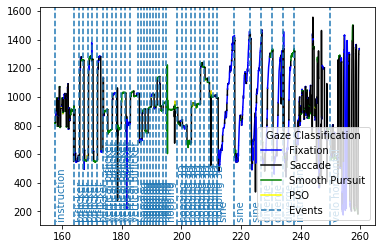

In [44]:
dis_seg_class = continuous_to_discrete(df["Timestamp"], df["REMODNAV_Segment"], df["REMODNAV_Class"])
dis_events = continuous_to_discrete(df["Timestamp"], df["Event_Idx"], df["Event_Name"])
plot_segmentation(df["Theta"], df["Timestamp"], dis_seg_class, dis_events)

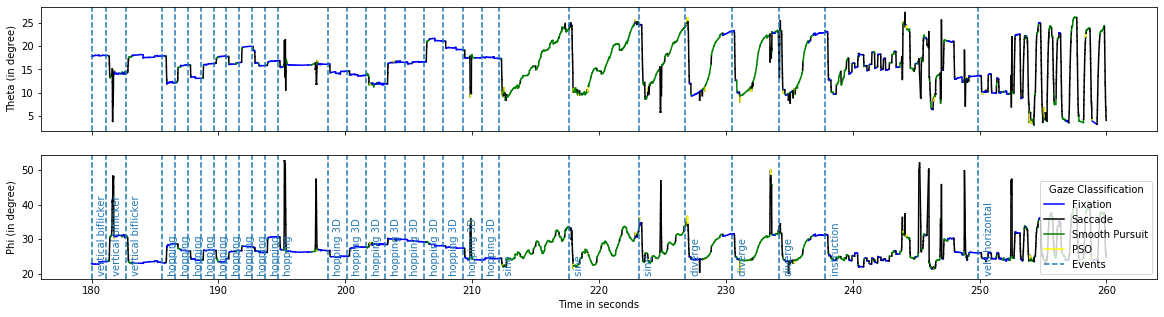

In [7]:
dis_seg_class = continuous_to_discrete(df["Timestamp"],
                                       df["NSLR_Segment"],
                                       df["NSLR_Class"])
dis_events = continuous_to_discrete(df["Timestamp"], df["Event_Idx"],
                                    df["Event_Name"])

fig, axes = plt.subplots(2, figsize=(20, 5), sharex=True)
        
plot_segmentation(df["Theta"], df["Timestamp"], dis_seg_class, dis_events, show_event_text=False, 
                  show_legend=False, ax=axes[0])
plot_segmentation(df["Phi"], df["Timestamp"], dis_seg_class, dis_events, ax=axes[1])

axes[0].set_ylabel("Theta (in degree)");
axes[1].set_ylabel("Phi (in degree)");   
axes[1].set_xlabel("Time in seconds");

Text(0, 0.5, 'Y Rotation in °')

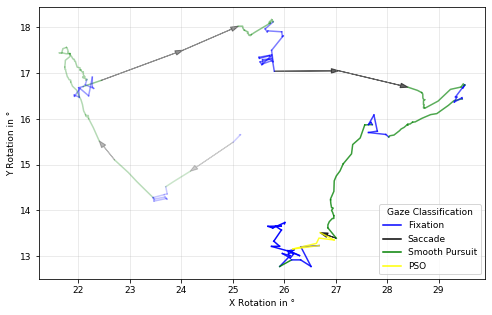

In [21]:
mask = df["Event_Name"] == "hopping 3D"
segments = continuous_to_discrete(df["Timestamp"], df["NSLR_Segment"], df["NSLR_Class"])


plt.figure(figsize=(8, 5))
plot_trajectory(df[mask]["Theta"], df[mask]["Phi"], df[mask]["Timestamp"], segments,
                show_legend=True, show_dots=False, show_clean=True, show_arrows=True, alpha_decay=1/150,
                color_dict=None, ax=None, plot_kwargs=dict(linestyle="-"),
                dot_kwargs=dict(marker="."))
plt.grid(alpha=0.3)
plt.xlabel("X Rotation in °")
plt.ylabel("Y Rotation in °")

Text(0.5, 0, 'Time')

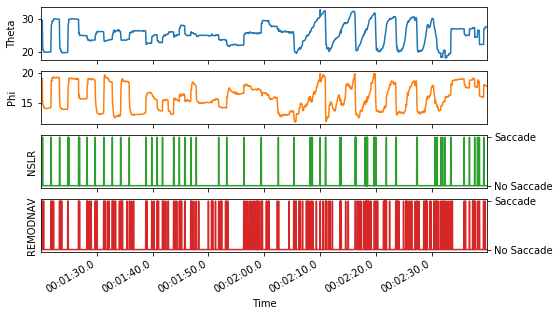

In [12]:
df["NSLR_SP"] = (df["NSLR_Class"] == "Saccade") * 1
df["REMODNAV_SP"] = (df["REMODNAV_Class"] == "Saccade") * 1
axes = df[["Theta", "Phi", "NSLR_SP", "REMODNAV_SP"]].plot(subplots=True, legend=False, figsize=(8, 5))


axes[2].yaxis.tick_right()
axes[2].set_yticklabels([0, "No Saccade", "Saccade"])
axes[3].yaxis.tick_right()
axes[3].set_yticklabels([0, "No Saccade", "Saccade"])
axes[0].set_ylabel("Theta")
axes[1].set_ylabel("Phi")
axes[2].set_ylabel("NSLR")
axes[3].set_ylabel("REMODNAV")
plt.xlabel("Time")

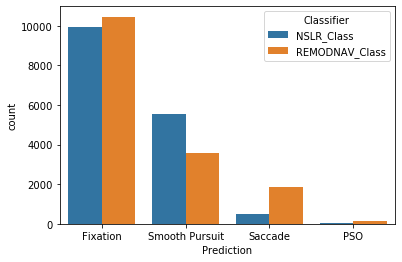

In [13]:
import seaborn as sns

df_melt = df[["NSLR_Class", "REMODNAV_Class"]].melt(var_name="Classifier",
                                                    value_name="Prediction")
sns.countplot(x="Prediction", hue="Classifier", data=df_melt)

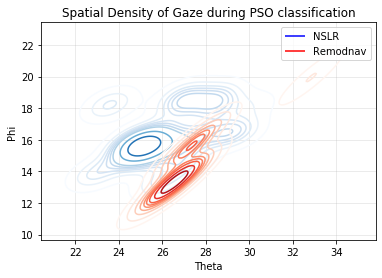

In [14]:
mask = df["REMODNAV_Class"] == "PSO"
sns.kdeplot(df[mask]["Theta"], df[mask]["Phi"], color='b',
            shade=False, cmap="Blues", shade_lowest=False)

mask = df["NSLR_Class"] == "PSO"
sns.kdeplot(df[mask]["Theta"], df[mask]["Phi"], color='b',
            shade=False, cmap="Reds", shade_lowest=False)

plt.title("Spatial Density of Gaze during PSO classification")
leg = plt.legend(["NSLR", "Remodnav"])
leg.legendHandles[0].set_color('blue')
leg.legendHandles[1].set_color('red')
plt.grid(alpha=0.3)

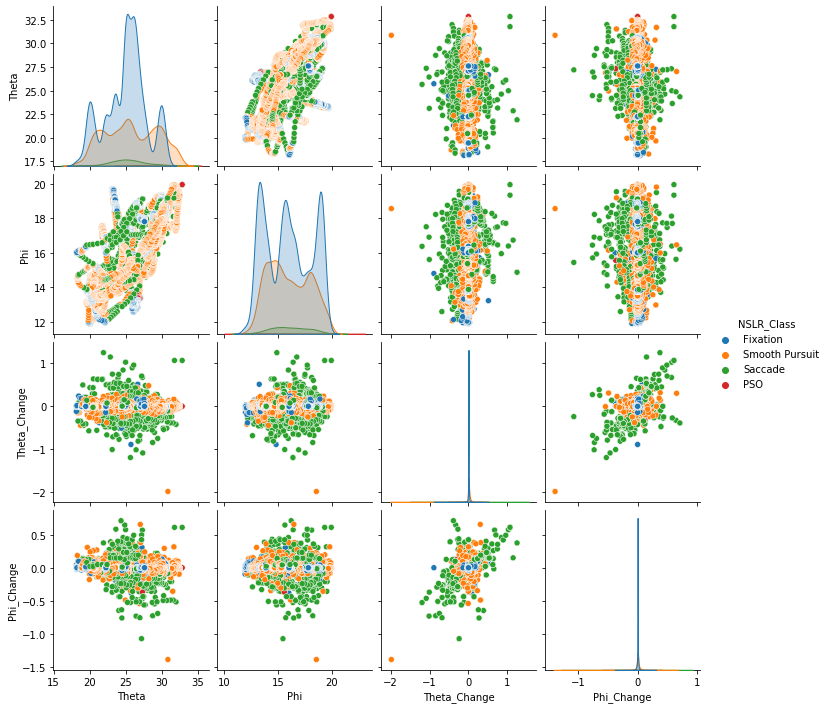

In [15]:
df["Theta_Change"] = df["Theta"] - df["Theta"].shift()
df["Phi_Change"] = df["Phi"] - df["Phi"].shift()
sns.pairplot(df[["Theta", "Phi", "Theta_Change", "Phi_Change", "NSLR_Class"]],
             hue="NSLR_Class")

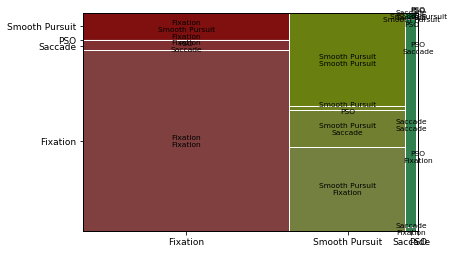

In [16]:
from statsmodels.graphics.mosaicplot import mosaic
plt.rcParams['font.size'] = 9.0
mosaic(df, ["NSLR_Class", "REMODNAV_Class"]);